## 1: Load Data

In [1]:
import json

def load_data(file_path):
    """
    Load the JSON file and return the data.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data.get("hits", [])  # Extract 'hits' directly if it's a list
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return []
    except json.JSONDecodeError:
        print(f"Error: Unable to decode JSON from file at {file_path}")
        return []

# File path to the new file
file_path = r"Negative_Search_unix.json"

# Load data
data = load_data(file_path)

# Check if the data is loaded successfully
if data:
    print(f"Loaded {len(data)} records from the file.")
else:
    print("No data available.")


Loaded 10 records from the file.


## 2: Normalize Data

In [2]:
# Inspect the first record in the loaded data
print(json.dumps(data[0], indent=4))  # Pretty print the first record


{
    "id": "93887d645a1a5980641cb68336d0d46b",
    "headline": "Systemadministrat\u00f6r inom Linux / UNIX",
    "brief": "P\u00e5 uppdrag av en av v\u00e5ra kunder i Stockholm\u00a0s\u00f6ker vi\u00a0dig som vill arbeta\u00a0med systemadministration\u00a0inom Linux / UNIX\u00a0i n\u00e5gra av Sveriges st\u00f6rsta och mest intressanta Linuxmilj\u00f6er. F\u00f6retaget\u00a0har flera tj\u00e4nster att fylla och\u00a0kan se en plats f\u00f6r b\u00e5de dig som \u00e4r i b\u00f6rjan av din Linux/UNIX-karri\u00e4r och dig med l\u00e4ngre erfarenhet!Tj\u00e4nsten blir en direktrekrytering s\u00e5 anst\u00e4llningen blir direkt hos v\u00e5r kund.",
    "occupation_group": {
        "label": "N\u00e4tverks- och systemtekniker m.fl.",
        "concept_id": "VCpu_5EN_bBt"
    },
    "occupation_field": {
        "label": "Data/IT",
        "concept_id": "apaJ_2ja_LuF"
    },
    "employer": {
        "name": "Centric Professionals AB"
    },
    "workplace_addresses": [],
    "publication_date

### Adjust the record_path and Normalize

In [3]:
import pandas as pd

def normalize_data(hits):
    """
    Flatten and clean the data into a Pandas DataFrame.
    """
    if not hits:
        print("No data available to normalize.")
        return pd.DataFrame()

    # Normalize the nested JSON data with the correct path
    df = pd.json_normalize(
        hits,
        record_path=["workplace_addresses"],  # Adjust the path to the correct key
        meta=["headline", "brief", "occupation_group.label", "occupation_field.label", "employer.name", "publication_date"],
        sep="_",
        errors="ignore"
    )

    # Clean and preprocess data
    df["region"] = df["region"].fillna("Unknown")
    df["occupation_field.label"] = df["occupation_field.label"].fillna("Unknown")
    df["publication_date"] = pd.to_datetime(df["publication_date"], errors='coerce')

    return df

# Normalize the data
df = normalize_data(data)

# Check if normalization was successful
if not df.empty:
    print("Data normalized successfully.")
    print(df.head())  # Display the first few rows
else:
    print("No data to normalize.")


Data normalized successfully.
  municipality_concept_id municipality region_concept_id          region  \
0            AvNB_uwa_6n6    Stockholm      CifL_Rzy_Mku  Stockholms län   
1            AvNB_uwa_6n6    Stockholm      CifL_Rzy_Mku  Stockholms län   

  country_concept_id  country                            headline  \
0       i46j_HmG_v64  Sverige           Machine Learning Engineer   
1       i46j_HmG_v64  Sverige  Senior Back-end Software Developer   

                                               brief occupation_group.label  \
0  We are looking for Machine Learning Engineer f...                    NaN   
1  At Arkus AI, a pioneering startup based in Sto...                    NaN   

  occupation_field.label employer.name publication_date  
0                Unknown           NaN       2024-11-21  
1                Unknown           NaN       2024-11-18  


##  3: Analyze Data

In [4]:
def analyze_by_region(df):
    """Analyze the number of job postings by region."""
    return df["region"].value_counts()

def analyze_by_occupation_field(df):
    """Analyze the number of job postings by occupation field."""
    return df["occupation_field.label"].value_counts()

def analyze_top_employers(df, top_n=10):
    """Identify the top employers based on job postings."""
    return df["employer.name"].value_counts().head(top_n)

# Analyze data
if not df.empty:
    jobs_by_region = analyze_by_region(df)
    print("\nJobs by Region:")
    print(jobs_by_region)

    jobs_by_field = analyze_by_occupation_field(df)
    print("\nJobs by Occupation Field:")
    print(jobs_by_field)

    top_employers = analyze_top_employers(df)
    print("\nTop Employers:")
    print(top_employers)
else:
    print("No data to analyze.")



Jobs by Region:
region
Stockholms län    2
Name: count, dtype: int64

Jobs by Occupation Field:
occupation_field.label
Unknown    2
Name: count, dtype: int64

Top Employers:
Series([], Name: count, dtype: int64)


## 4: Visualize Data

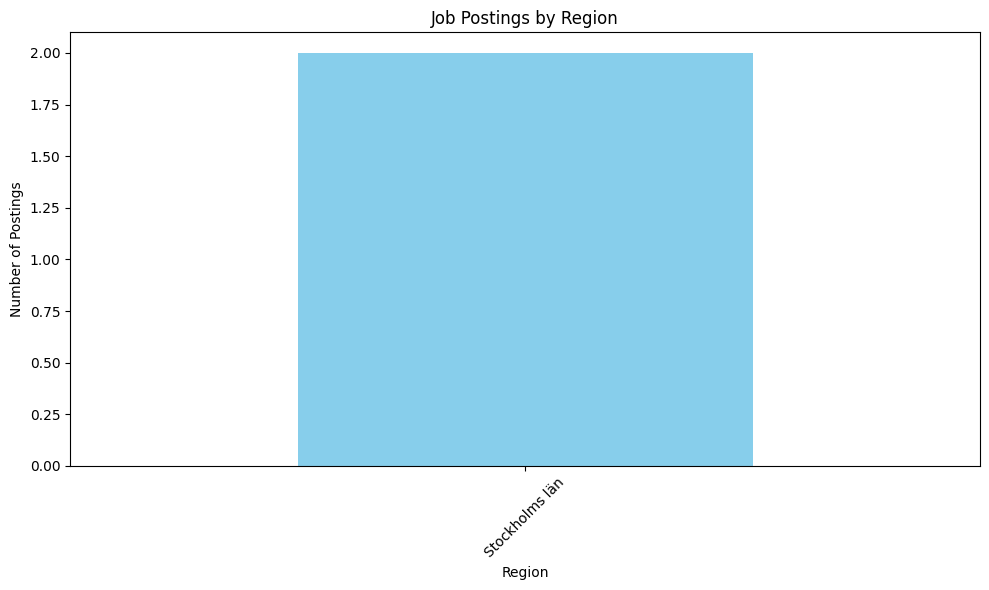

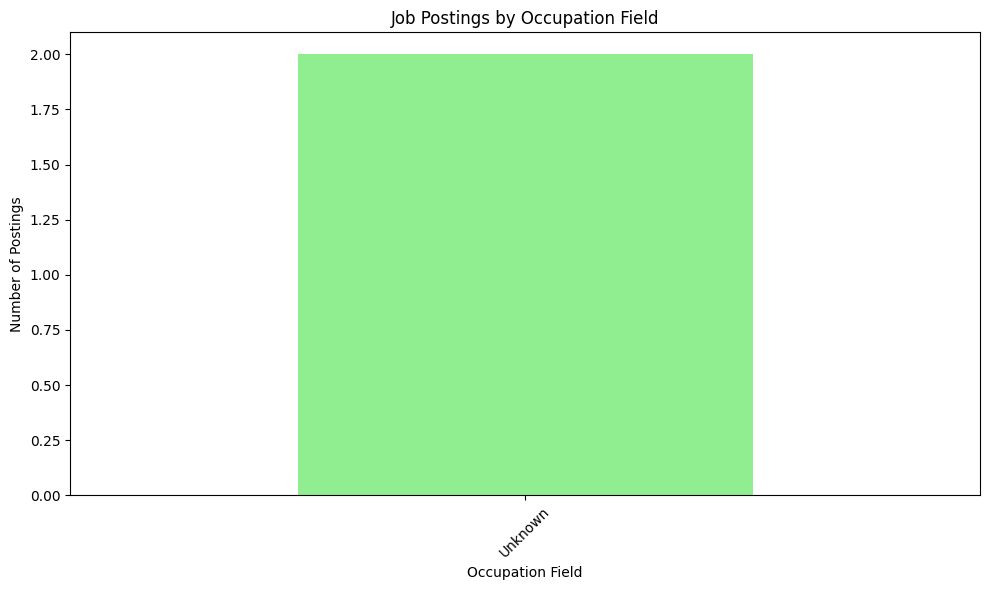

In [5]:
import matplotlib.pyplot as plt

def visualize_data(data, title, xlabel, ylabel, color="skyblue"):
    """Create a bar plot for the given analysis data."""
    if data.empty:
        print(f"No data available to visualize for: {title}")
        return

    plt.figure(figsize=(10, 6))
    data.plot(kind="bar", color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualize data
if not df.empty:
    visualize_data(jobs_by_region, "Job Postings by Region", "Region", "Number of Postings")
    visualize_data(jobs_by_field, "Job Postings by Occupation Field", "Occupation Field", "Number of Postings", color="lightgreen")
else:
    print("No data to visualize.")


## Step 5: Save the Cleaned Data

In [6]:
def save_cleaned_data(df, output_path, file_format="csv"):
    """
    Save the cleaned DataFrame to a specified file format.
    
    Parameters:
    df (pd.DataFrame): The cleaned DataFrame to save.
    output_path (str): The file path to save the data.
    file_format (str): The format to save the file ('csv' or 'excel').
    
    Returns:
    None
    """
    try:
        if df.empty:
            print("No data to save.")
            return
        
        if file_format == "csv":
            df.to_csv(output_path, index=False, encoding="utf-8")
            print(f"Data successfully saved as CSV to {output_path}")
        elif file_format == "excel":
            df.to_excel(output_path, index=False, encoding="utf-8")
            print(f"Data successfully saved as Excel to {output_path}")
        else:
            print("Unsupported file format. Use 'csv' or 'excel'.")
    except Exception as e:
        print(f"An error occurred while saving the file: {e}")

# Save cleaned data
output_csv_path = r"cleaned_solutions_negative_search_unix.csv"
save_cleaned_data(df, output_csv_path, file_format="csv")


Data successfully saved as CSV to cleaned_solutions_negative_search_unix.csv
